In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import librosa.display
import IPython.display

from src.data import NSynthDataset
from src.models import Autoencoder, SpatialTimeAutoencoder, AutoencoderLite

/home/ec2-user/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
model = Autoencoder(h_dim=128)
model.load_state_dict(torch.load('train_results/autoencoder/20200508-184120/model-11000.weights'))

<All keys matched successfully>

In [3]:
val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=[0], 
    feature_type='mel',
    scaling='normalize',
    resize=(128, 128)
)

In [17]:
features = val_dataset[16]

In [18]:
model.eval()
features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
outputs = model(features)

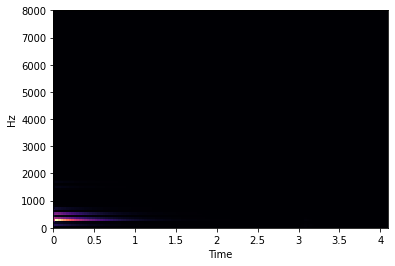

In [19]:
librosa.display.specshow(features.numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

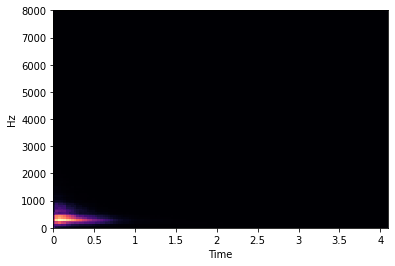

In [20]:
librosa.display.specshow(outputs.detach().numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

In [15]:
class Autoencoder2(nn.Module):
    def __init__(self, h_dim=1024):
        super(Autoencoder2, self).__init__()

        # (1, 128, 251)
        self.conv1 = nn.Conv2d(1, 32, 4, padding=(1, 4), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
        self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
        self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        self.conv5 = nn.Conv2d(256, 512, 4, padding=1, stride=(2, 2))

        self.fc_enc = nn.Linear(512*4*8, h_dim, bias=True)
        self.fc_dec = nn.Linear(h_dim, 512*4*8, bias=True)

        self.deconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.deconv5 = nn.ConvTranspose2d(32, 1, (2, 3), padding=(0, 3), stride=2)
        
        # (1, 40, 126)
#         self.conv1 = nn.Conv2d(1, 32, 4, padding=1, stride=(2, 2))
#         self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
#         self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
#         self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        
#         self.fc_enc = nn.Linear(3584, h_dim, bias=True)
#         self.fc_dec = nn.Linear(h_dim, 3584, bias=True)

#         self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 3), stride=2)
#         self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 3), stride=2)
#         self.deconv4 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
    
        x = x.view(x.size(0), -1)
        return F.relu(self.fc_enc(x))
        
    def decode(self, h):
        h = F.relu(self.fc_dec(h))
        h = h.view(h.size(0), 512, 4, 8)
        
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        h = F.relu(self.deconv3(h))
        h = F.relu(self.deconv4(h))
        h = self.deconv5(h)
        return torch.sigmoid(h)
        
    def forward(self, x):
        h = self.encode(x)
        outputs = self.decode(h)
        return outputs

In [113]:
model2 = Autoencoder2(128)
model2.load_state_dict(torch.load('train_results/autoencoder/20200430-175135/model-8000.weights'))

<All keys matched successfully>

In [114]:
val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=[0], 
    feature_type='mel',
    scaling='normalize'
)

In [132]:
features = val_dataset[12]

In [133]:
model2.eval()
features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
outputs = model2(features)

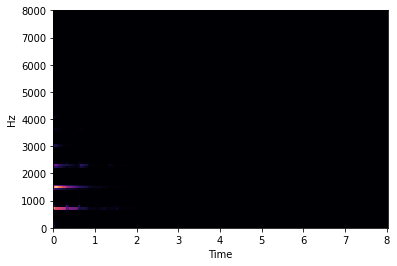

In [134]:
librosa.display.specshow(features.numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

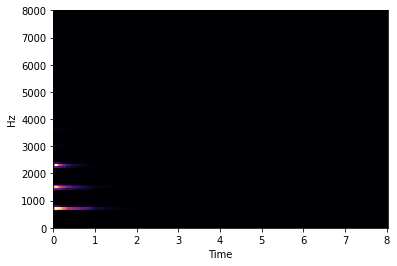

In [135]:
librosa.display.specshow(outputs.detach().numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')